### 1. Decision Trees

In [174]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
np.random.seed(3116)

In [16]:
col = ["parents","has_nurs","form","children","housing","finance","social","health","nursery"]

In [26]:
data = pd.read_csv("nursery.csv",names=col)
y = data.pop('nursery')

,parents,has_nurs,form,children,housing,finance,social,health
0,usual,proper,complete,1,convenient,convenient,nonprob,recommended
1,usual,proper,complete,1,convenient,convenient,nonprob,priority
2,usual,proper,complete,1,convenient,convenient,nonprob,not_recom
3,usual,proper,complete,1,convenient,convenient,slightly_prob,recommended
4,usual,proper,complete,1,convenient,convenient,slightly_prob,priority
...,...,...,...,...,...,...,...,...
12955,great_pret,very_crit,foster,more,critical,inconv,slightly_prob,priority
12956,great_pret,very_crit,foster,more,critical,inconv,slightly_prob,not_recom
12957,great_pret,very_crit,foster,more,critical,inconv,problematic,recommended
12958,great_pret,very_crit,foster,more,critical,inconv,problematic,priority


In [158]:
X_train = np.asarray(data.iloc[:9072,:])
X_test = np.asarray(data.iloc[9072:11016,])
X_val = data.iloc[11016:,]
y_train = np.asarray(y[:9072])
y_test = np.asarray(y[9072:11016])
y_val = y[11016:]

In [159]:
class Node:
    def __init__(self):
        
        self.right = None
        self.left = None
        
        self.column = None
        self.threshold = None
        
        self.node_accuracy = None
        self.depth = None
        
        self.leaf_node = False

In [198]:
class DecisionTreeClassifier:
    def __init__(self, max_depth = 3, min_samples_leaf = 1, min_samples_split = 2, type_criteria = ''):
        
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.min_samples_split = min_samples_split
        self.type = type_criteria
        self.pred_classes = None
        self.Tree = None
    
    def quality_criterion(self, y):
        if(self.type == 'MCR'):
            correct = 0
            for j in range(len(y)):
                if(y[j] in self.pred_classes):
                    correct+=1
            acc = (correct/len(y))
            return acc
        else:
            class_prob = []
            for c in self.pred_classes:
                p = len(y[y==c])/len(y)
                class_prob.append(p**2)
            return np.sum(class_prob)

    def mcr(self, acc):
        return 1-acc
    
    def split_factor(self, y):
        acc = self.quality_criterion(y)
        return self.mcr(acc)

    def calcBestSplit(self, X, y):
        '''
            bestsplit: is the best column from which the tree could be split
            bestVal: is the threshold used for splitting the tree (which falls in left and which on right)
            best_mcr: is the max value of the misclassified rate (1 means everything is misclassified/accuracy is zero)
            best_info: min value of info gain
            splitval = splitting criterion for all of label y
        '''
        bestsplit = None
        bestVal = None
        best_mcr = 1
        best_info = -9999
        splitval = self.split_factor(y)
        #go through each column one by one
        for i in range(X.shape[1]):
            #print("Column: ",i)
            col = X[:,i]
            #go through each element of the column and first assign the first element as threhold for split
            for xc in col:
                th = xc
                #if greater than threshold then go to right else left node
                right = y[col>th]
                left = y[col<=th]
                if(len(right)==0 or len(left)==0):
                    continue
                #calculate the split criterion for these left and right nodes
                sp_left = self.split_factor(left)
                sp_right = self.split_factor(right)
                #If the type of quality criterion used is MCR, simply add the left and right value
                if(self.type == "MCR"):
                    mis_class = sp_left+sp_right
                    #check if the new rate is less than the best value of rate.
                    if(mis_class<best_mcr):
                        #update all the values of best column for split, best splitting threshold and best rate
                        bestsplit = i
                        bestVal = th
                        best_mcr = mis_class
                #this part is for quality criterion as information gain
                else:
                    mis_class = splitval
                    #formula for information gain
                    mis_class -= sp_left+sp_right
                    #if higher 
                    if(mis_class>best_info):
                        bestsplit = i
                        bestVal = th
                        best_mcr = mis_class
        best_column = X[:,bestsplit]
        xleft = X[best_column<=bestVal,:]
        xright = X[best_column>bestVal,:]
        yleft = y[best_column<=bestVal]
        yright = y[best_column>bestVal]
        return bestsplit, bestVal, xleft, yleft, xright, yright

    def opt_decisiontree(self, X, y, node):
        #if the level is the bottom-most layer
        if node.depth >= self.max_depth:
            node.leaf_node = True
            return
        #if X has less than 2 records and unable to split it further
        if(len(X) < self.min_samples_split):
            node.leaf_node = True
            return
        # if only one type of label is in the node
        if len(np.unique(y)) == 1:
            node.leaf_node = True
            return
        bestsplit, bestVal, xleft, yleft, xright, yright = self.calcBestSplit(X, y)
        #if no further split can be done
        if bestsplit is None:
            node.leaf_node = True
        #if the number of nodes in left or right is less than 2, then further splitting cannot be done
        if len(xleft) < self.min_samples_leaf or len(xleft) < self.min_samples_leaf:
            node.leaf_node = True
            return
        
        #take the best column which can be used for splitting
        node.column = bestsplit
        node.threshold = bestVal
        #create the left node from current node
        node.left = Node()
        node.left.depth = node.depth + 1
        node.left.node_accuracy = self.quality_criterion(yleft)
        #create node to the right side from the current node
        node.right = Node()
        node.right.depth = node.depth + 1
        node.right.node_accuracy = self.quality_criterion(yright)
        #recursively build the tree from the root and calculate the best suitability for split
        self.opt_decisiontree(xleft,yleft,node.left)
        self.opt_decisiontree(xright,yright,node.right)
    
    def fit(self, X, y):
        self.pred_classes = np.unique(y)
        self.Tree = Node()
        self.Tree.depth = 1
        self.Tree.node_accuracy = self.quality_criterion(y)
        self.opt_decisiontree(X,y,self.Tree)
        self.bfs(self.Tree)
    
    def bfs(self,node):
        listnode = [node]
        bfs_list = []
        count = 0
        while(len(listnode)>0):
            bfs_list.append(count)
            count += 1
            #print(list_node)
            pop_node = listnode.pop(0)
            if pop_node.left is not None:
                bfs_list.append(count)
            if pop_node.right is not None:
                bfs_list.append(count+1)
        print(bfs_list)
    def predictone(self,X,node):
        if node.leaf_node:
            return node.node_accuracy
        if any(X[node.column])<=node.threshold:
            pred = self.predictone(X,node.left)
        else:
            pred = self.predictone(X,node.right)
        return pred
    
    def predict(self,X):
        preds = []
        for val in X:
            p = np.argmax(self.predictone(X,self.Tree))
            preds.append(p)
        return preds

In [173]:
decisiontree = DecisionTreeClassifier(3,1,2,'MCR')
decisiontree.fit(X_train,y_train)

[0, 1, 2]


In [170]:
decisiontree1 = DecisionTreeClassifier(3,1,5,'infogain')
decisiontree1.fit(X_train,y_train)

[0, 1, 2]


### 2. Gradient Boosted Decision Trees

In [182]:
Xm = []
ym = []
for i in range(10):
    Xr,yr = make_moons(100,noise=0.01*i)
    Xm.append(Xr)
    ym.append(yr)
Xm = np.array(Xm).reshape(-1,2)
ym = np.array(ym).reshape(-1)
X_train_mm = np.asarray(Xm[:700,:])
X_test_mm = np.asarray(Xm[700:850,:])
X_val_mm = Xm[850:,:]
y_train_mm = np.asarray(ym[:700])
y_test_mm = np.asarray(ym[700:850])
y_val_mm = ym[850:]

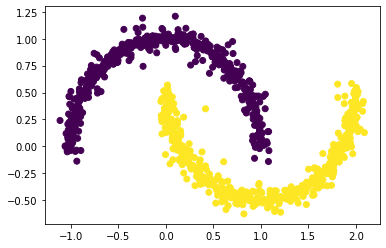

In [183]:
plt.scatter(Xm[:,0],Xm[:,1],c = ym)

Generate a collection of Decision trees from the decision tree class defined earlier in the previous problem. I have used 5 trees/estimators for this task where each have properties like min split number, max depth, and so on. I have used the gradient of sigmoid function for the boosting and for each newly predicted value, I have updated it by using the gradient and learning rate. The prediction is pretty simple as well, just find the prediction from the testing data, and update the prediction using the product of learning rate and the predicition. Lastly, find the max of the y_pred which is the prediction.

In [209]:
class DecisionTreeCollection:
    def __init__(self,estimators,lr,min_samples_split,min_samples_leaf,max_depth):
        self.estimators = estimators
        self.lr = lr
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.max_depth = max_depth
        self.trees = []
        for i in range(estimators):
            tree = DecisionTreeClassifier(self.max_depth,self.min_samples_leaf,self.min_samples_split,"infogain")
            self.trees.append(tree)
    def sigmoid(self,x):
        return 1/(1+np.exp(-x))
    def grad(self,y, y_pred):
        return self.sigmoid(y_pred) - y
    def cross_entropy_loss(self,y,y_pred):
        return -(y*np.log(y_pred) + (1-y)*np.log(1-y_pred)).sum()
    def fit(self,x,y):
        pred = np.ones(y.shape)
        for i in range(self.estimators):
            gradient = self.grad(y,pred)
            self.trees[i].fit(x,gradient)
            nextpred = self.trees[i].predict(x)
            pred = pred - np.multiply(self.lr,nextpred)
    def predict(self,X):
        y_pred = []
        for tree in self.trees:
            pred = tree.predict(X)
            pred = np.multiply(self.lr,pred)
            if len(y_pred)==0:
                y_pred = -pred
            else:
                y_pred = y_pred - pred
        y_pred = self.sigmoid(y_pred)
        y_pred = np.max(y_pred)
        return y_pred


In [210]:
tree_collection = DecisionTreeCollection(5,0.01,2,1,2)
tree_collection.fit(X_train_mm,y_train_mm)
y_pred = tree_collection.predict(X_test_mm)
cost = tree_collection.cross_entropy_loss(y_test_mm,y_pred)
cost

[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]


103.9720770839918

## References:
1. https://www.youtube.com/watch?v=NxEHSAfFlK8&ab_channel=AssemblyAI
2. https://kawahara.ca/how-to-compute-truefalse-positives-and-truefalse-negatives-in-python-for-binary-classification-problems/
3. https://favtutor.com/blogs/breadth-first-search-python
4. https://blog.mattbowers.dev/gradient-boosting-machine-from-scratch